In [5]:
#
# In this notebook we exampine moprhology's rol,e of preicpitaiton system
#
%load_ext autoreload
%autoreload 2
import xarray as xr
import numpy as np
from global_ocean_mask import globe
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.stats import binned_statistic, binned_statistic_2d, pearsonr, linregress
from src.regions import *
from src.pf_stats import *
from src.plotting import *
from src.radar import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
CORE_THRESH = 10
regions = [
    afc_region(), 
    cio_region(), 
    wmp_region(), 
    h01_region(), 
    h05_region(), 
    epo_region(),
    sam_region(),
    sas_region()
]

In [24]:
pf_stats = pd.concat(
    [load_pf_stats(r, maxpr_min=0, just_tropics=False) for r in regions]
)

In [25]:
radar = xr.concat(
    [load_merged_radar(r) for r in regions], 
    dim='features'
)

In [28]:
assert(radar.features.size==pf_stats.shape[0])

In [29]:
valid_id = pf_stats['max_precip']>=CORE_THRESH
pf_stats = pf_stats[valid_id]
radar = radar.isel(features=valid_id)

/Users/pedro/miniconda3/envs/extreme_precipitation_in_gpm/lib/python3.12/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/Users/pedro/miniconda3/envs/extreme_precipitation_in_gpm/lib/python3.12/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/Users/pedro/miniconda3/envs/extreme_precipitation_in_gpm/lib/python3.12/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/Users/pedro/miniconda3/envs/extreme_precipitation_in_gpm/lib/python3.12/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))


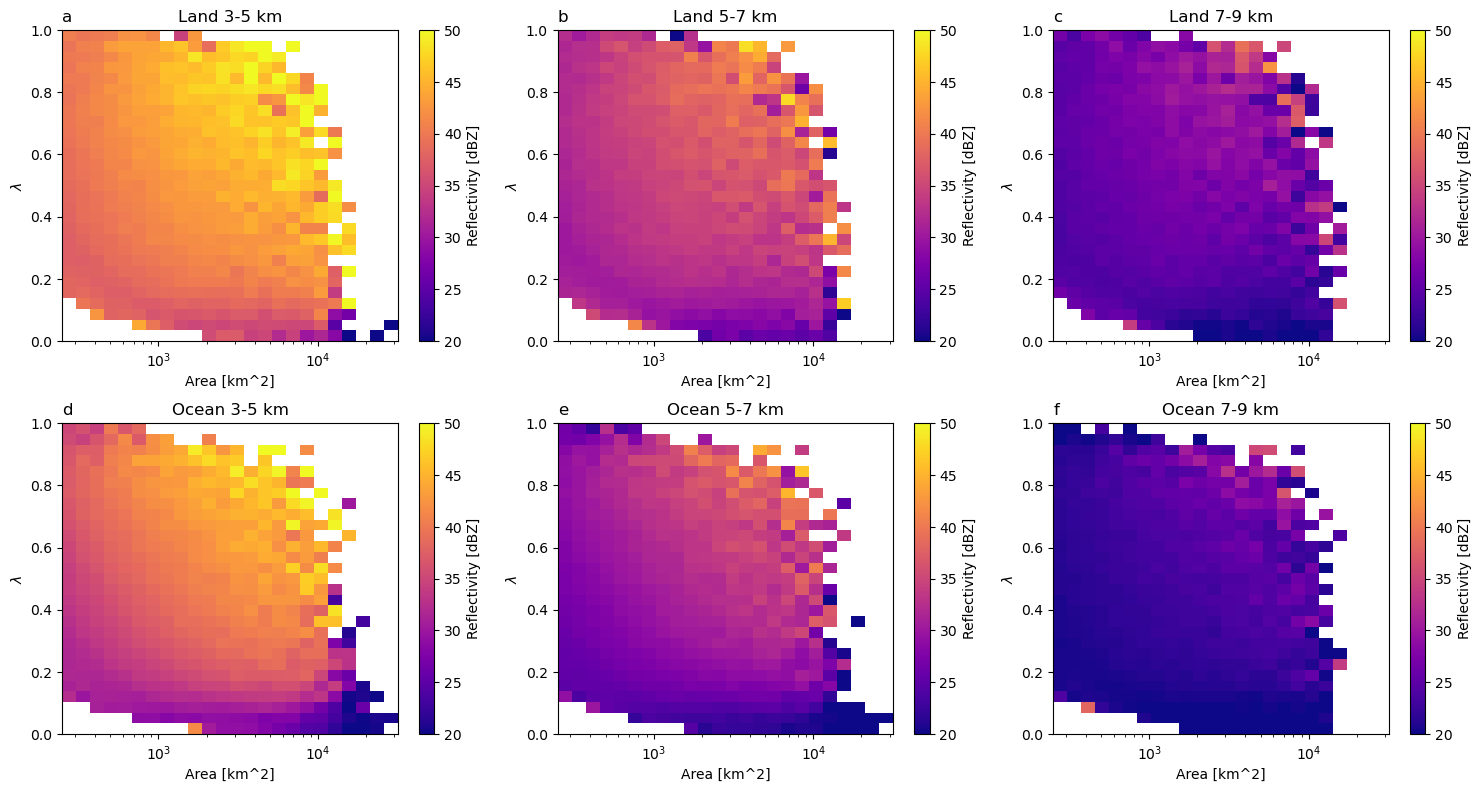

In [47]:
#
# Plot the layer mean reflectivity
#
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15, 8))

area = pf_stats['num_pixels'] * 25
loc = pf_stats[f'rainiest_{CORE_THRESH}mmhr_cluster_precip_8conn']/pf_stats['total_precip']
area_bins = np.logspace(np.log10(250), 4.5, 25)
loc_bins = np.linspace(0, 1, 30)

layer_slices = [slice(3, 5), slice(5, 7), slice(7, 9)]

is_land_id = globe.is_land(pf_stats['mean_latitude'], pf_stats['mean_longitude'])
is_ocean_id = globe.is_ocean(pf_stats['mean_latitude'], pf_stats['mean_longitude'])

land_axs = axs[0,:]
land_radar = radar.isel(features=is_land_id)
for i, ax in enumerate(land_axs):
    mean_z = land_radar['max_precip_refl'].sel(alt=layer_slices[i]).mean('alt')
    mean = binned_statistic_2d(
        loc[is_land_id], 
        area[is_land_id], 
        bins=[loc_bins, area_bins],
        values=np.log10(mean_z) * 10,  # convert reflectivity
        statistic=np.nanmean
    ).statistic
    
    x_mesh, y_mesh = np.meshgrid(area_bins, loc_bins)
    c = ax.pcolormesh(
        x_mesh, 
        y_mesh, 
        mean,
        cmap=plt.cm.plasma, 
        norm=colors.Normalize(vmin=20, vmax=50)
    )
    # Add colorbar
    fig.colorbar(c, ax=ax, label='Reflectivity [dBZ]')
    
    # Label axes & title
    ax.set_xscale('log')
    ax.set_xlabel('Area [km^2]')
    ax.set_ylabel(r'$\lambda$')
    ax.set_title(f"Land {layer_slices[i].start}-{layer_slices[i].stop} km")
    ax.set_title(chr(ord('a') + i), loc='left')
ocean_axs = axs[1,:]
ocean_radar = radar.isel(features=is_ocean_id)
for i, ax in enumerate(ocean_axs):
    mean_z = ocean_radar['max_precip_refl'].sel(alt=layer_slices[i]).mean('alt')
    mean = binned_statistic_2d(
        loc[is_ocean_id], 
        area[is_ocean_id], 
        bins=[loc_bins, area_bins],
        values=np.log10(mean_z) * 10,
        statistic=np.nanmean
    ).statistic
    
    x_mesh, y_mesh = np.meshgrid(area_bins, loc_bins)
    c = ax.pcolormesh(
        x_mesh, 
        y_mesh, 
        mean,
        cmap=plt.cm.plasma, 
        norm=colors.Normalize(vmin=20, vmax=50)
    )
    # Add colorbar
    fig.colorbar(c, ax=ax, label='Reflectivity [dBZ]')
    
    # Label axes & title
    ax.set_xscale('log')
    ax.set_xlabel('Area [km^2]')
    ax.set_ylabel(r'$\lambda$')
    ax.set_title(f"Ocean {layer_slices[i].start}-{layer_slices[i].stop} km")
    ax.set_title(chr(ord('d') + i), loc='left')
plt.tight_layout(pad=1)

save_figure(fig, 'Fig04_LayerMeans')

In [33]:
mean_z

<xarray.DataArray 'max_precip_refl' (features: 375159)> Size: 3MB
dask.array<mean_agg-aggregate, shape=(375159,), dtype=float64, chunksize=(7539,), chunktype=numpy.ndarray>
Coordinates:
    time      (features) datetime64[ns] 3MB dask.array<chunksize=(7539,), meta=np.ndarray>
  * features  (features) <U68 102MB 'pf_0048.GPM2Ku7_uw4_20150101.083719_to_2...